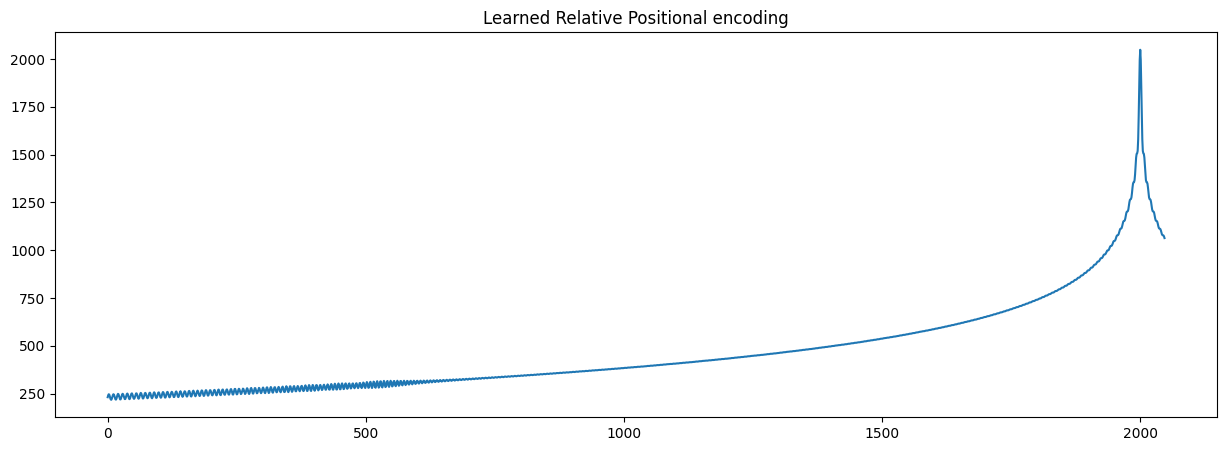

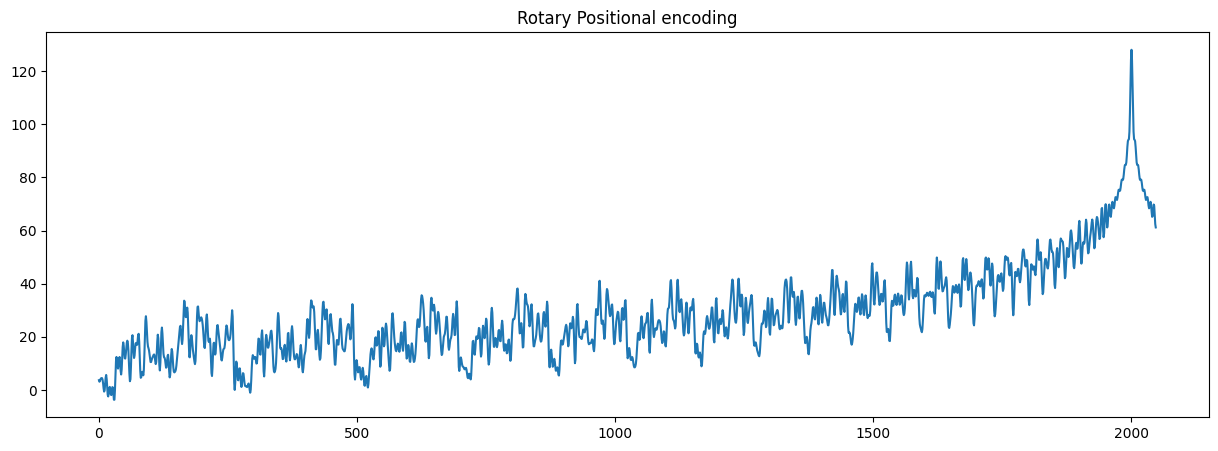

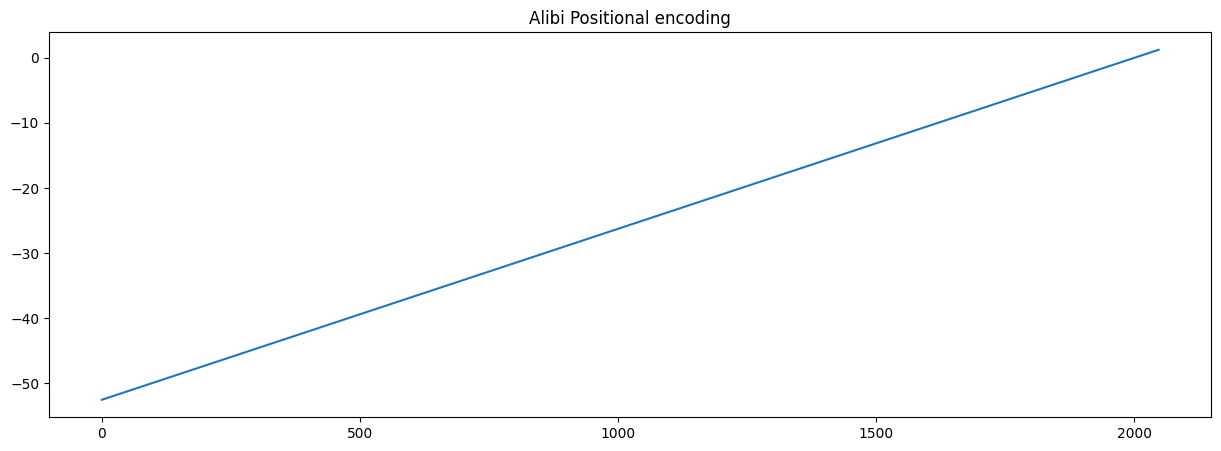

In [305]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np


# 可学习相对位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout_prob: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        encodings = self.get_positional_encoding(d_model, max_len)
        self.register_buffer('positional_encodings', encodings, False)

    @staticmethod
    def get_positional_encoding(d_model: int, max_len: int):
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
        div_term = torch.exp(two_i * -(math.log(10000.0) / d_model))
        encodings = torch.zeros(max_len, d_model)
        encodings[:, 0::2] = torch.sin(position * div_term)
        encodings[:, 1::2] = torch.cos(position * div_term)
        return encodings.unsqueeze(0).requires_grad_(False)

    def forward(self, x: torch.Tensor):
        pe = self.positional_encodings[:x.shape[1]].detach().requires_grad_(False)
        return self.dropout(x + pe)


# rotary相对位置编码
class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
            self.sin_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
        )


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed, q, k


def _get_interleave(n):
    def _get_interleave_power_of_2(n):
        start = 2 ** (-(2 ** -(math.log2(n) - 3)))
        ratio = start
        return [start * ratio**i for i in range(n)]

    if math.log2(n).is_integer():
        return _get_interleave_power_of_2(n)
    else:
        closest_power_of_2 = 2 ** math.floor(math.log2(n))
        return (
            _get_interleave_power_of_2(closest_power_of_2)
            + _get_interleave(2 * closest_power_of_2)[0::2][: n - closest_power_of_2]
        )

def _fill_with_neg_inf(t):
    """FP16-compatible function that fills a tensor with -inf."""
    return t.float().fill_(float("-inf")).type_as(t)


def _buffered_future_mask(tensor, maxpos, alibi, attn_heads):
    _future_mask = torch.triu(_fill_with_neg_inf(torch.zeros([maxpos, maxpos])), 1)
    _future_mask = _future_mask.unsqueeze(0) + alibi
    new_future_mask = _future_mask.to(tensor)
    return new_future_mask[: tensor.shape[0] * attn_heads, :maxpos, :maxpos]


def _gen_alibi_mask(tensor, n_head, max_pos):
    slopes = torch.Tensor(_get_interleave(n_head))

    position_point = torch.arange(max_pos) - max_pos + 1
    position_point = position_point.unsqueeze(0).unsqueeze(0).expand(n_head, -1, -1)
    diag = torch.diag(position_point[0]) # -2048/4096
    position_point = position_point - diag.unsqueeze(0).unsqueeze(0).transpose(-1, -2)
    
    alibi = slopes.unsqueeze(1).unsqueeze(1) * position_point

    alibi = alibi.view(n_head, 1, max_pos)
    alibi_mask = torch.triu(_fill_with_neg_inf(torch.zeros([max_pos, max_pos])), 1)
    alibi_mask = alibi_mask.unsqueeze(0) + alibi
    return alibi_mask



seq_len = 2048
head_dim = 128
model_dim = 4096
n_head = model_dim // head_dim

see_position = 2000
see_head = 20

plt.figure(figsize=(15, 5))
pe = PositionalEncoding.get_positional_encoding(model_dim, seq_len)
d = pe.matmul(pe.transpose(2, 1))
# d = torch.nn.functional.normalize(d, dim=-1)
plt.plot(np.arange(seq_len), d[0, see_position, :].numpy())
plt.title("Learned Relative Positional encoding")
plt.show()

rotary = LlamaRotaryEmbedding(head_dim, max_position_embeddings=seq_len, base=10000, device=None)
cos, sin = rotary(key, seq_len=seq_len)
position_ids = torch.arange(seq_len).unsqueeze(0)
query_states = torch.ones(1, n_head, seq_len,  head_dim)
key_states = torch.ones(1, n_head, seq_len, head_dim)
query_states, key_states, q, k = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)
attn_weights = torch.matmul(query_states, key_states.transpose(2, 3))
# attn_weights = torch.nn.functional.normalize(attn_weights, dim=-1)

plt.figure(figsize=(15, 5))
# 每个头的值分布一样
plt.plot(np.arange(seq_len), attn_weights[0, see_head, see_position, :].numpy())
plt.title("Rotary Positional encoding")
plt.show()


tensor = torch.ones(1, seq_len, model_dim)
slopes = torch.Tensor(_get_interleave(n_head))
position_point = (torch.arange(seq_len) - seq_len + 1)
position_point = (position_point.unsqueeze(0).unsqueeze(0).expand(n_head, seq_len, -1))
diag = torch.diag(position_point[0])
position_point = position_point - diag.unsqueeze(0).unsqueeze(0).transpose(-1, -2)
alibi = slopes.unsqueeze(1).unsqueeze(1) * position_point
mask = _buffered_future_mask(tensor, seq_len, alibi, n_head)

plt.figure(figsize=(15, 5))
# 每个头的值分布不一样
plt.plot(np.arange(seq_len), alibi[see_head, see_position, :].numpy())
plt.title("Alibi Positional encoding")
plt.show()